In [10]:
import logging
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from data.data_preparer import DataPreparer
from data.data_reader import DataReader
from predictor.implementations.multilayer_perceptron import MultiLayerPerceptronPredictor
from tools.RestaurantReviewsDataset import RestaurantReviewsDataset
from tools.config_parser import ConfigParser
from tools.restaurant_profiles_manager import RestaurantProfilesManager
from tools.user_profiles_manager import UserProfilesManager
from tools.model_loader import ModelLoader

logging.basicConfig(level=logging.INFO)
while str(os.getcwd())[-3:] != 'src':  # Execute from src-directory root
    os.chdir('..')

In [11]:
train_data, test_data = DataReader().read_data()

Reading files from cache:  33%|███▎      | 1/3 [00:00<00:00, 28.31it/s, (current: reviews)]INFO:root:Only using 100% of the dataset


In [12]:
def load_model_with_test_data(model_path: os.PathLike, b_test_f, r_test_f, u_test_f) -> tuple[MultiLayerPerceptronPredictor, tuple[pd.DataFrame, pd.Series]]:
    # Create valid trained model
    trained_model = ModelLoader.load_mlp_model(model_path)
    # Create associated test data for validation
    input_test, output_test = DataPreparer.transform_data(b_test_f, r_test_f, u_test_f, trained_model.user_profiles_params, trained_model.business_profiles_params)

    return trained_model, (input_test, output_test)


def find_worst_model_with_index(model_list) -> tuple[float, int]:
    highest_loss = max([model_f[1] for model_f in model_list])
    corresponding_index = [i for i, model_f in enumerate(model_list) if model_f[1] == highest_loss][0]
    return highest_loss, corresponding_index


# For analysing trained models with different input vector, such as different user profiles
def get_all_models_with_loss():
    models_dir = [dir_entry.path for dir_entry in list(os.scandir(ConfigParser().get_value("predictor_model", "model_dir"))) if dir_entry.path.endswith('.pt')]
    models_with_loss_f = []
    for _ in range(len(models_dir)):
        models_with_loss_f.append((None, 99))
    for model_path in tqdm(models_dir, desc="Loading in models"):

        model_f, train_test_data_f = load_model_with_test_data(model_path, *test_data)

        highest_loss, highest_index = find_worst_model_with_index(models_with_loss_f)
        current_loss = min(model_f.loss_history)
        if current_loss < highest_loss:
            models_with_loss_f[highest_index] = (model_f, current_loss, train_test_data_f)
    models_with_loss_f = sorted(models_with_loss_f, key=lambda data: data[1])
    return models_with_loss_f

# For analysing trained models with the same input vector, such as the best user profiles
def get_all_models_best_data():
    models_dir = [dir_entry.path for dir_entry in list(os.scandir(ConfigParser().get_value("predictor_model", "model_dir"))) if dir_entry.path.endswith('.pt')]
    models_with_loss_f = []

    # Load data
    _, input_test, _, output_test = DataPreparer.parse_data_train_test(train_data, test_data, (UserProfilesManager().get_best(), RestaurantProfilesManager().get_best()), cache_index_if_available=23)
    for model_path in tqdm(models_dir, desc="Loading in models"):
        model_f = ModelLoader.load_mlp_model(model_path)
        models_with_loss_f.append((model_f, model_f.loss_history[-1], (input_test, output_test)))
    models_with_loss_f = sorted(models_with_loss_f, key=lambda data: data[1])
    return models_with_loss_f

In [13]:
models_with_loss = get_all_models_best_data()  # Collecting trained models for analysis with the same input vector, such as the best user profiles
# models_with_loss = get_all_models_with_loss()  # Collecting trained models for analysis with different input vector, such as different user profiles

INFO:root:Reading ML input/output from cache 23


Loading in models:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:Model loaded from predictor/Models/mlp\mlp6_2023-05-20_08h30__EPOCHS=400_ADAGRAD_LR=0.0002_LOSS=0.0771_100procent.pt.


In [14]:
# Run small testset on all the models to evaluate performance in a true recommendation environment
results = []

for model, _, train_test_data in models_with_loss:
    logging.info(f"Testing model with User Profiles: {model.user_profiles_params} and Business Profiles: {model.business_profiles_params}")
    model.eval()  # Prepare layers of model for evaluation
    with torch.no_grad():
        testX, testY = train_test_data

        dl = RestaurantReviewsDataset(testX.to_numpy(), testY.to_numpy())
        test_loader = DataLoader(dl, batch_size=len(testX))
        for x, y in test_loader:
            # Prepare data
            x, y = DataPreparer.get_tensor_for_ml(x, y)
            # Compute predictions and loss

            predictions = model(x)
            predictions = predictions.cpu().detach().numpy().squeeze().transpose()
            y = y.cpu().detach().numpy().squeeze().transpose()
            result = pd.DataFrame(data=[predictions, y]).transpose()
            result.columns = ['predicted', 'actual']
            result['predicted'] = result['predicted'].transform(lambda x: round(x * 4 + 1))
            result['actual'] = result['actual'].transform(lambda x: int(x * 4 + 1))
            result['difference'] = abs(result['predicted'] - result['actual'])
            results.append(result)

INFO:root:Testing model with User Profiles: {'current_model_name': 'online_model_400top_97.bert', 'use_sentiment_in_scores': False, 'approx_mode': False, 'approx_normalization': True, 'approx_amount_top_n': 5, 'filter_useful_topics': False} and Business Profiles: {'current_model_name': 'online_model_400top_97.bert', 'use_sentiment_in_scores': True, 'approx_mode': False, 'approx_normalization': True, 'approx_amount_top_n': 5, 'filter_useful_topics': False}


Histogram of differences between prediction and actual:
Model used: <class 'predictor.implementations.multilayer_perceptron6.MultiLayerPerceptron6Predictor'>
Layers: 6, optimizer: ADAGRAD, LR: 0.0002
Accuracy: 32.12%


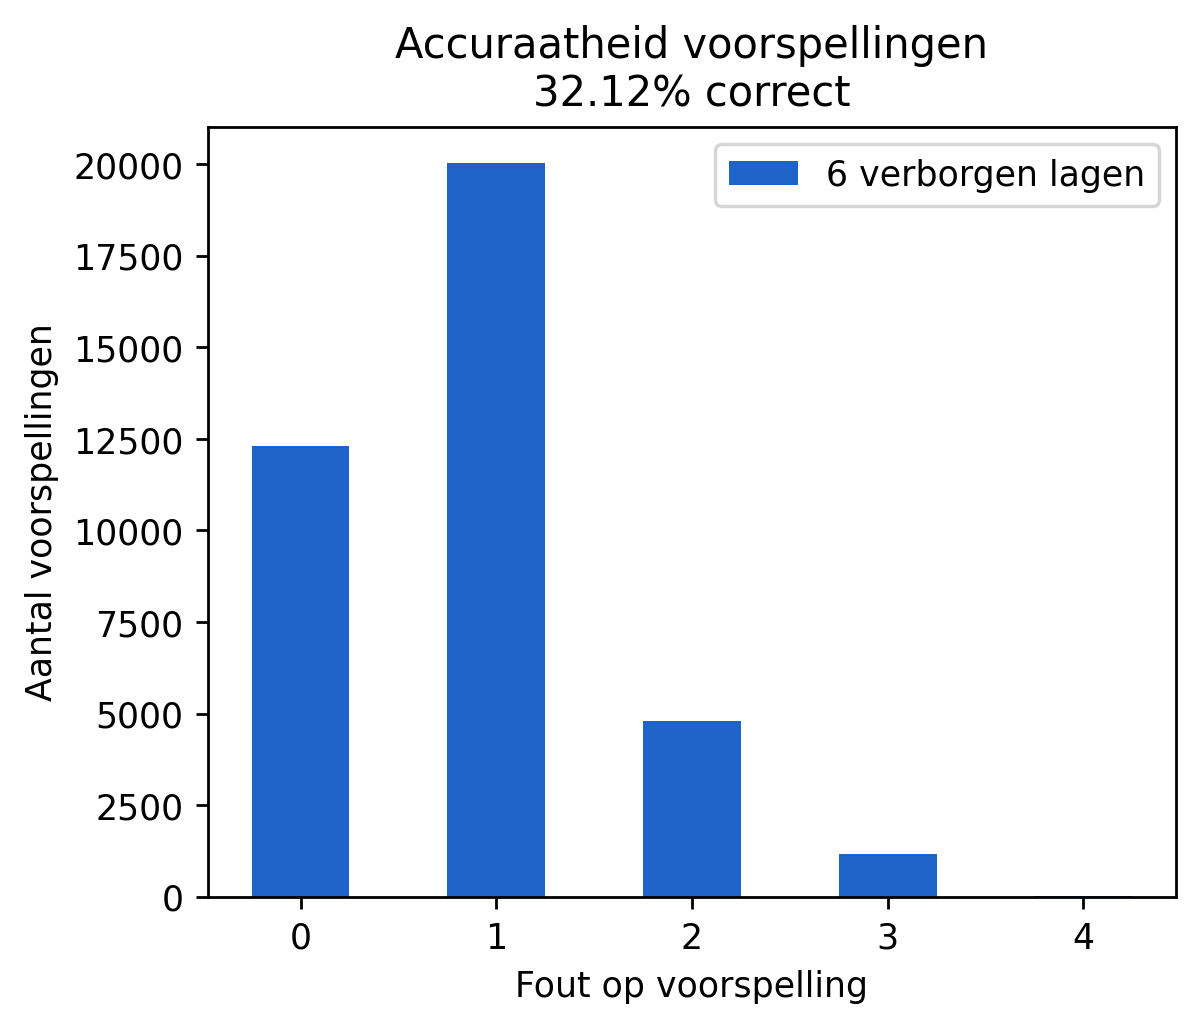

,predicted,actual,difference
0,4,5,1
1,4,5,1
2,5,4,1
3,4,4,0
4,4,4,0
...,...,...,...
38298,4,1,3
38299,4,4,0
38300,3,1,2
38301,3,1,2


In [15]:
index = 0
result = results[index]
model: MultiLayerPerceptronPredictor = models_with_loss[index][0]
print("Histogram of differences between prediction and actual:")
print(f"Model used: {model.__class__}")
print(f"Layers: {model.version}, optimizer: {model.optimizer}, LR: {model.lr}")
print(f"Accuracy: {((result['difference'] == 0).sum() / len(result) * 100):.2f}%")
plt.figure(dpi=250, figsize=(5, 4))
plt.hist(result['difference'], bins=[0, 1, 2, 3, 4, 5], align='left', rwidth=0.5, label=f"{model.version} verborgen lagen", color='#1E64C8')
plt.legend()
plt.ylabel("Aantal voorspellingen")
plt.xlabel("Fout op voorspelling")
plt.title(f"Accuraatheid voorspellingen\n{((result['difference'] == 0).sum() / len(result) * 100):.2f}% correct")
plt.show()
result.to_excel(f"results_{model.version}_layer.xlsx")  # Om in Latex te kopiëren
result

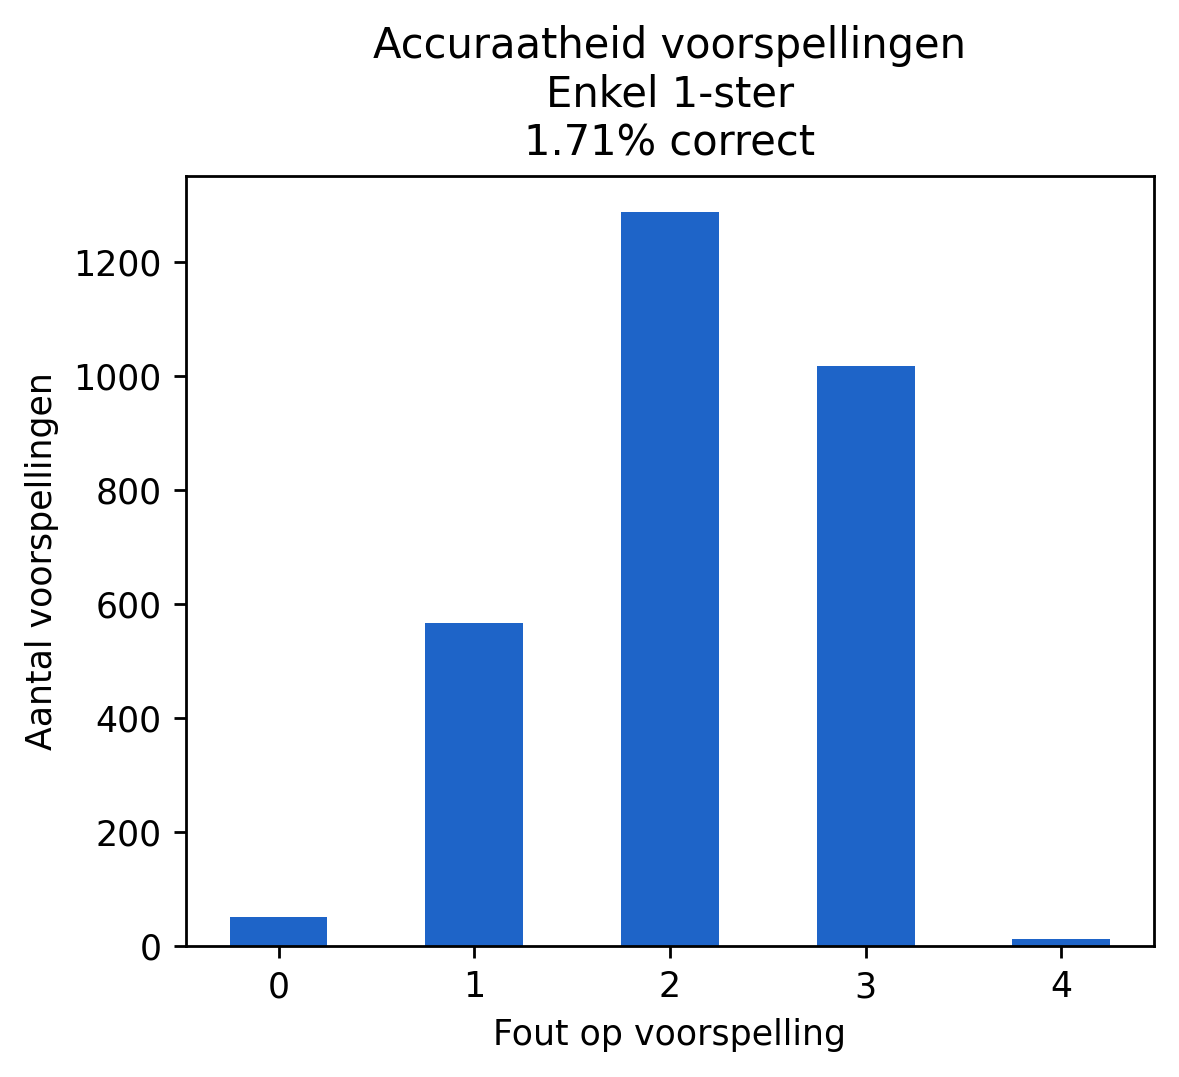

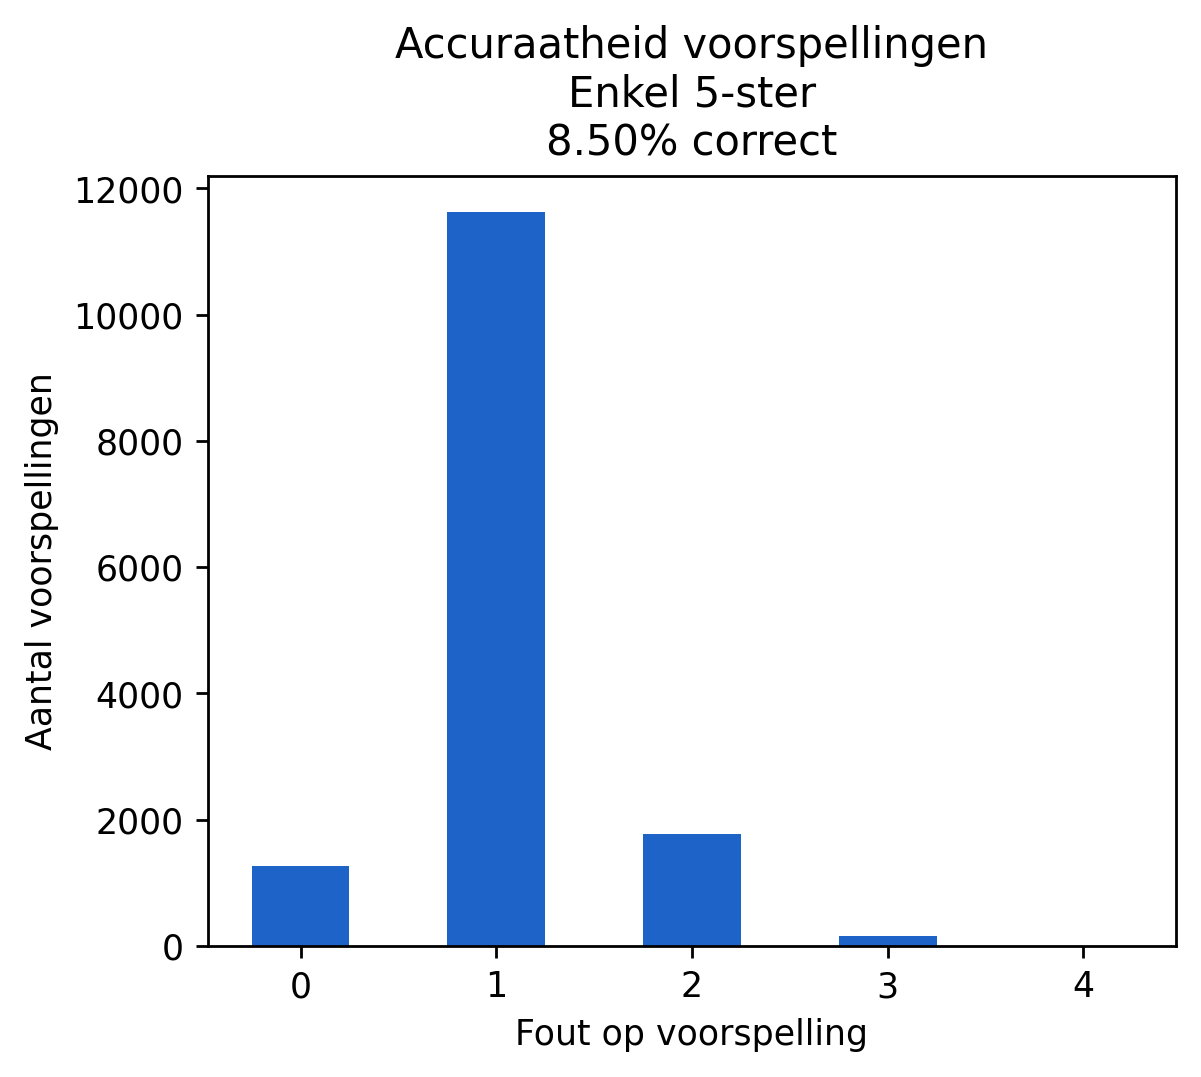

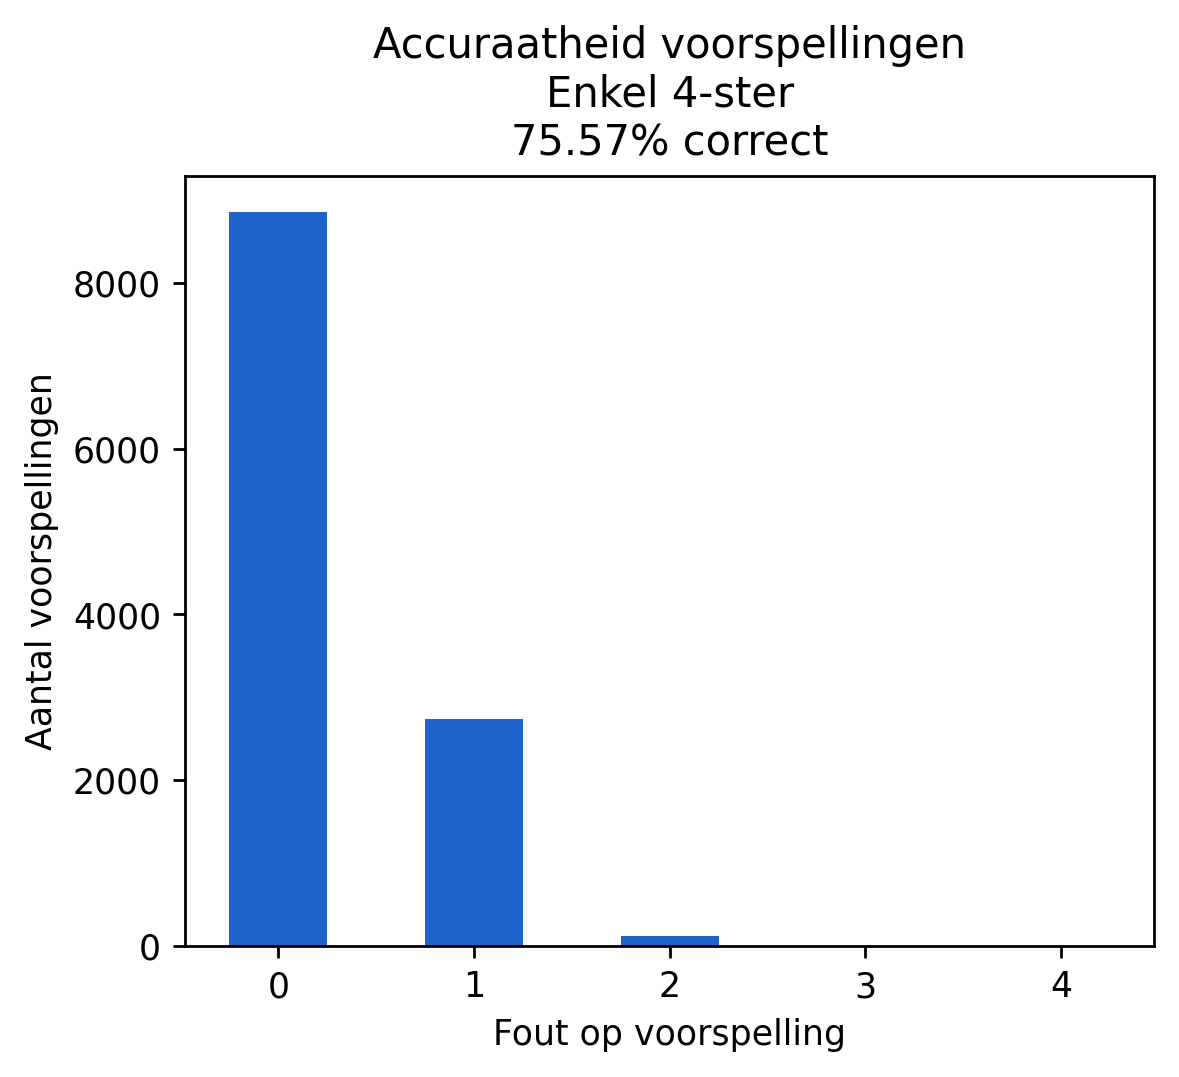

In [21]:
result_extreme_waarden_1 = result[result['actual'] == 1]
result_extreme_waarden_5 = result[result['actual'] == 5]
result_waarden_4 = result[result['actual'] == 4]

plt.figure(dpi=250, figsize=(5, 4))
plt.hist(result_extreme_waarden_1['difference'], bins=[0, 1, 2, 3, 4, 5], align='left', rwidth=0.5, label=f"{model.version} verborgen lagen", color='#1E64C8')
plt.ylabel("Aantal voorspellingen")
plt.xlabel("Fout op voorspelling")
plt.title(f"Accuraatheid voorspellingen\nEnkel 1-ster\n{((result_extreme_waarden_1['difference'] == 0).sum() / len(result_extreme_waarden_1) * 100):.2f}% correct")
plt.show()


plt.figure(dpi=250, figsize=(5, 4))
plt.hist(result_extreme_waarden_5['difference'], bins=[0, 1, 2, 3, 4, 5], align='left', rwidth=0.5, label=f"{model.version} verborgen lagen", color='#1E64C8')
plt.ylabel("Aantal voorspellingen")
plt.xlabel("Fout op voorspelling")
plt.title(f"Accuraatheid voorspellingen\nEnkel 5-ster\n{((result_extreme_waarden_5['difference'] == 0).sum() / len(result_extreme_waarden_5) * 100):.2f}% correct")
plt.show()

plt.figure(dpi=250, figsize=(5, 4))
plt.hist(result_waarden_4['difference'], bins=[0, 1, 2, 3, 4, 5], align='left', rwidth=0.5, label=f"{model.version} verborgen lagen", color='#1E64C8')
plt.ylabel("Aantal voorspellingen")
plt.xlabel("Fout op voorspelling")
plt.title(f"Accuraatheid voorspellingen\nEnkel 4-ster\n{((result_waarden_4['difference'] == 0).sum() / len(result_waarden_4) * 100):.2f}% correct")
plt.show()

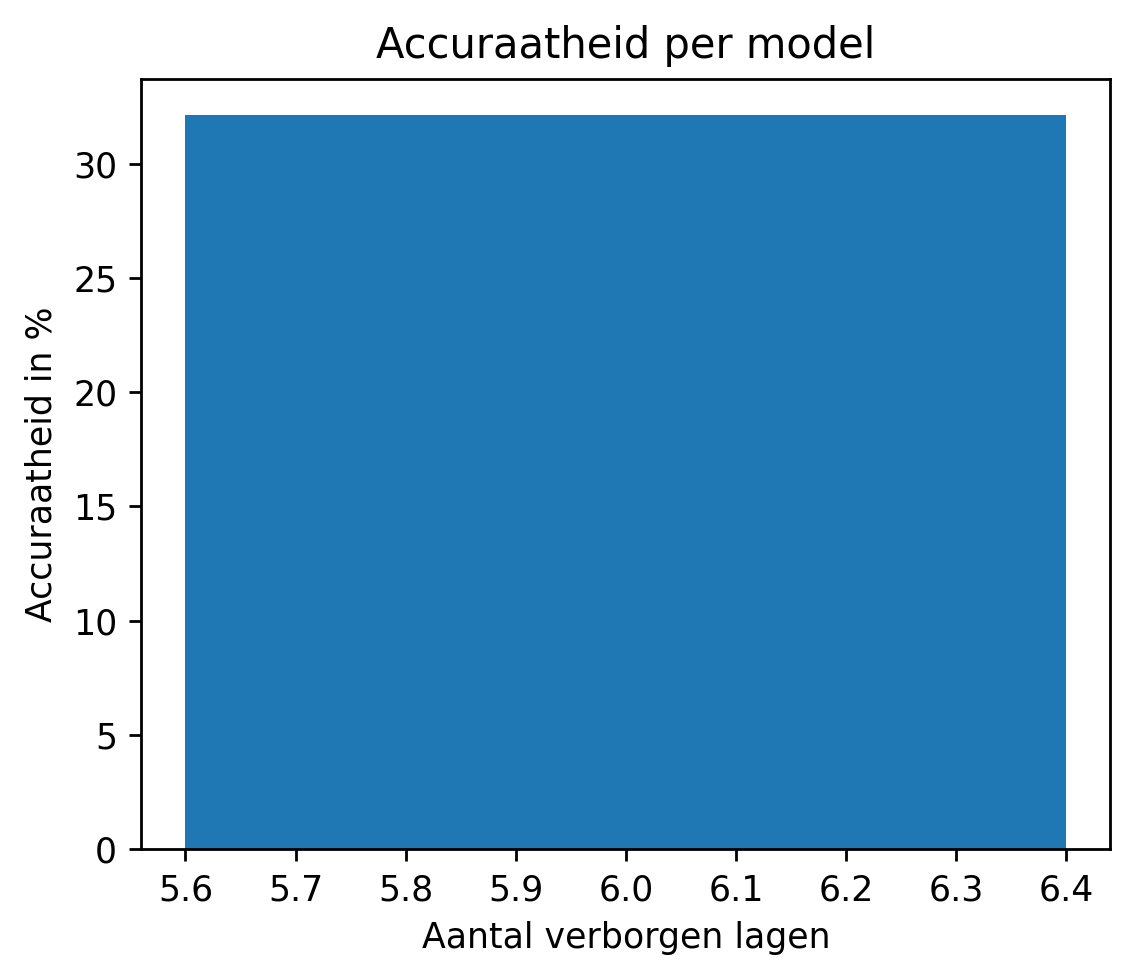

In [16]:
accs = []
versions = []



for index in range(len(results)):
    result = results[index]
    model, _, _ = models_with_loss[index]
    accs.append((result['difference'] == 0).sum() / len(result) * 100)
    versions.append(model.version)

plt.figure(dpi=250, figsize=(5, 4))
for index in range(len(results)-1, -1, -1):
    plt.bar(versions[index], accs[index])

plt.ylabel("Accuraatheid in %")
plt.xlabel("Aantal verborgen lagen")
plt.title(f"Accuraatheid per model")
plt.show()



In [17]:
plt.figure(figsize=(8,4.5), dpi=250)
plot = plt.plot(models_with_loss[7][0].loss_history, label=f"{models_with_loss[7][0].version} verborgen lagen")
for model_i, _, _ in models_with_loss[6::-1]:
    plot += plt.plot(model_i.loss_history, label=f"{model_i.version} verborgen lagen")
plt.ylim(0.075, 0.105)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE (normalized scores)")
plt.title("Loss voor verschillende netwerkarchitecturen")
plot

IndexError: list index out of range

<Figure size 2000x1125 with 0 Axes>